# Garbage Classification (Machine Learning only)
- Feature extraction: Bag of Word + Color Histogram
- Data Augmentation
- Dimensionality reduction: PCA


In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)


#### Load dataset

In [2]:
W, H = IMG_SIZE = (128, 128)

DATASET_PATH = "/mnt/c/Users/PC/PycharmProjects/garbage_classification/garbage-dataset"

#Lấy danh sách tất cả các folder
classes = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print("Classes found:", classes)

X_images, y_labels = [], []

for label in tqdm(classes, desc="Loading dataset"):
    folder = os.path.join(DATASET_PATH, label)
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        #Đọc ảnh
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        #Chuẩn hóa ảnh về dạng BGR 3 kênh
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        X_images.append(img)
        y_labels.append(label)

X_images = np.array(X_images, dtype=np.uint8)
y_labels = np.array(y_labels)
print("Loaded:", X_images.shape, y_labels.shape)

Classes found: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


Loading dataset: 100%|██████████| 10/10 [02:15<00:00, 13.55s/it]


Loaded: (19762, 128, 128, 3) (19762,)


#### Train/Test split

In [3]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_images, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)
print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)

Train: (15809, 128, 128, 3) Test: (3953, 128, 128, 3)


#### Data augmentation

In [4]:
def augment_image(img):
    img = cv2.resize(img, IMG_SIZE)
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)
    angle = np.random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((W//2, H//2), angle, 1)
    img = cv2.warpAffine(img, M, (W, H))
    factor = 0.7 + np.random.rand() * 0.6
    img = np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    return img

X_train_aug = []
y_train_aug = []

for img, label in zip(X_train_raw, y_train_raw):
    X_train_aug.append(img)
    y_train_aug.append(label)
    for _ in range(2):
        #Tạo 2 ảnh tăng cường cho mỗi ảnh gốc nhưng vẫn giữ nguyên nhãn
        X_train_aug.append(augment_image(img))
        y_train_aug.append(label)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)
print("Train after augmentation:", X_train_aug.shape, y_train_aug.shape)

Train after augmentation: (47427, 128, 128, 3) (47427,)


#### Feature extraction

In [6]:
VOCAB_SIZE = 700

orb = cv2.ORB_create(nfeatures=700)
descriptors_list = []

for img in tqdm(X_train_aug, desc="ORB Detect (Train)"):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect
    kp, des = orb.detectAndCompute(gray, None)
    if des is not None:
        descriptors_list.append(des)

#Kiểm tra nếu không tìm thấy đặc trưng nào
if len(descriptors_list) == 0:
    raise ValueError("Error")

#Gộp tất cả descriptors lại thành 1 ma trận lớn
all_descriptors = np.vstack(descriptors_list)
print(f"Total descriptors found: {all_descriptors.shape}")

#CLUSTERING (MINIBATCH K-MEANS)
kmeans = MiniBatchKMeans(
    n_clusters=VOCAB_SIZE,
    batch_size=2048,
    random_state=42,
    n_init='auto'
)
kmeans.fit(all_descriptors)
print("Vocabulary built successfully.")

#BoW + COLOR HISTOGRAM
def extract_features_bow(img, kmeans_model):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = orb.detectAndCompute(gray, None)

    bow_hist = np.zeros(VOCAB_SIZE, dtype=np.float32)

    if des is not None:
        #Dự đoán xem mỗi descriptor thuộc cụm từ vựng nào
        preds = kmeans_model.predict(des)
        # Đếm tần suất
        unique, counts = np.unique(preds, return_counts=True)
        for u, c in zip(unique, counts):
            bow_hist[u] = c

    #Chuẩn hóa L2 cho BoW
    bow_hist = cv2.normalize(bow_hist.reshape(1, -1), None, norm_type=cv2.NORM_L2).flatten()

    #Color Histogram
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_hist = cv2.calcHist([hsv], [0], None, [16], [0, 180]).flatten()
    s_hist = cv2.calcHist([hsv], [1], None, [16], [0, 256]).flatten()
    v_hist = cv2.calcHist([hsv], [2], None, [16], [0, 256]).flatten()

    # Ghép và Chuẩn hóa L2 cho Màu
    color_feat = np.concatenate([h_hist, s_hist, v_hist])
    color_feat = cv2.normalize(color_feat.reshape(1, -1), None, norm_type=cv2.NORM_L2).flatten()

    #Kết hợp cả hai
    return np.concatenate([bow_hist, color_feat])

#TRÍCH XUẤT CHO TRAIN VÀ TEST
X_train_feats = []
for img in tqdm(X_train_aug, desc="Extract Train"):
    X_train_feats.append(extract_features_bow(img, kmeans))
X_train_feats = np.array(X_train_feats, dtype=np.float32)

X_test_feats = []
for img in tqdm(X_test_raw, desc="Extract Test"):
    X_test_feats.append(extract_features_bow(img, kmeans))
X_test_feats = np.array(X_test_feats, dtype=np.float32)

print("Features extracted:", X_train_feats.shape, X_test_feats.shape)

#LABEL ENCODING
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_test_enc = le.transform(y_test_raw)
unique_classes, counts = np.unique(y_train_enc, return_counts=True)
class_names = le.inverse_transform(unique_classes)

ORB Detect (Train): 100%|██████████| 47427/47427 [00:21<00:00, 2212.36it/s]


Total descriptors found: (5989312, 32)
Vocabulary built successfully.


Extract Test: 100%|██████████| 3953/3953 [00:03<00:00, 1097.55it/s]

Features extracted: (47427, 748) (3953, 748)


#### Visualization

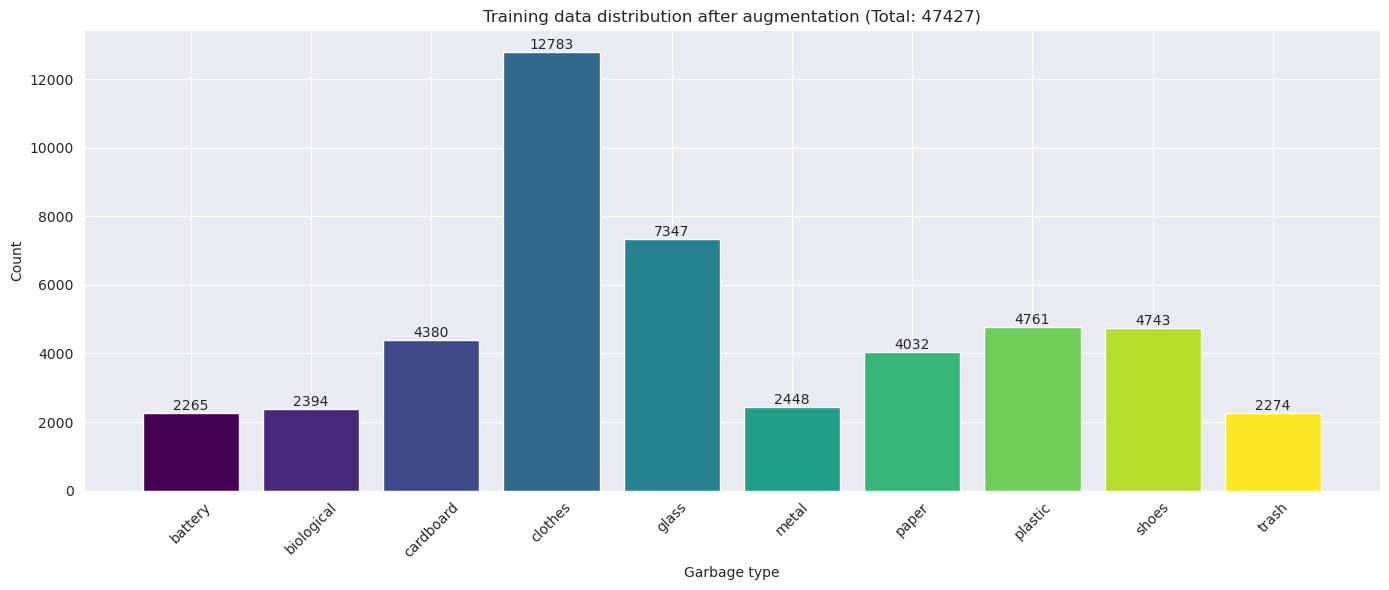

In [7]:
plt.figure(figsize=(14,6))
bars = plt.bar(class_names, counts, color=plt.cm.viridis(np.linspace(0,1,len(class_names))))
plt.title(f"Training data distribution after augmentation (Total: {len(y_train_enc)})")
plt.xlabel("Garbage type")
plt.ylabel("Count")
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=height,
        s=f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.tight_layout()
plt.show()

#### Dimensionality reduction

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Chuẩn hoá dữ liệu về phân phối chuẩn N(0,1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_test_scaled = scaler.transform(X_test_feats)

#PCA
n_pca_components = 200
print(f"Applying PCA with {n_pca_components} components...")
pca = PCA(n_components=n_pca_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Applying PCA with 200 components...


#### Training model and Prediction & Evaluation

##### SVM

In [9]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    C=0.5,
    gamma="scale",
    probability=True
)

svm.fit(X_train_pca, y_train_enc)

,C,0.5
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=5,
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

rf.fit(X_train_pca, y_train_enc)

,n_estimators,500
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


##### Linear Regression

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000
)

lr.fit(X_train_pca, y_train_enc)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


##### Prediction & Evaluation

SVM Evaluation
Accuracy : 0.5691879585125221
Precision: 0.5695473229349728
Recall   : 0.5691879585125221
F1-score : 0.5477655951396685


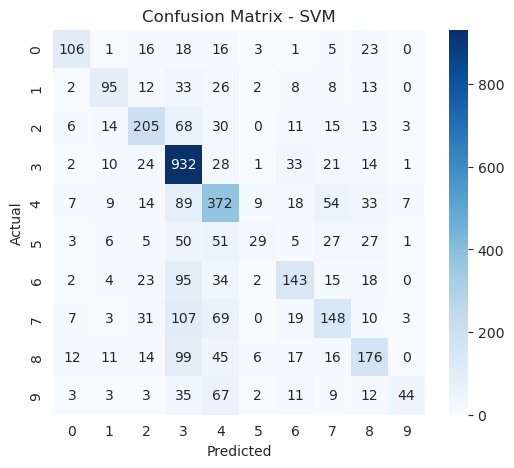

Random Forest Evaluation
Accuracy : 0.3956488742727043
Precision: 0.42937838945061785
Recall   : 0.3956488742727043
F1-score : 0.30401209824943626


/home/quocha16/miniconda3/envs/Classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


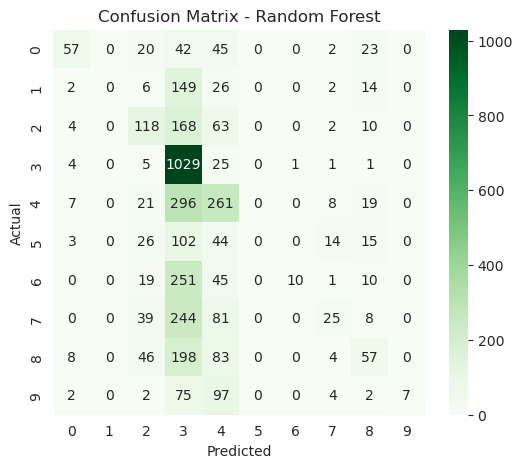

Logistic Regression Evaluation
Accuracy : 0.5003794586390083
Precision: 0.48404935241580266
Recall   : 0.5003794586390083
F1-score : 0.4800097158872187


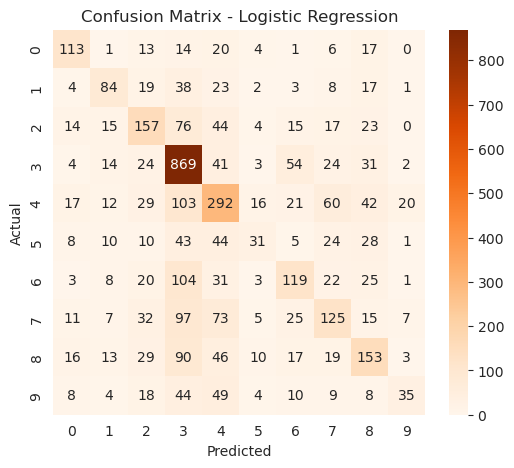

In [12]:
#SVM
y_pred_svm = svm.predict(X_test_pca)

acc_svm = accuracy_score(y_test_enc, y_pred_svm)
pre_svm = precision_score(y_test_enc, y_pred_svm, average="weighted")
rec_svm = recall_score(y_test_enc, y_pred_svm, average="weighted")
f1_svm  = f1_score(y_test_enc, y_pred_svm, average="weighted")

print("SVM Evaluation")
print("Accuracy :", acc_svm)
print("Precision:", pre_svm)
print("Recall   :", rec_svm)
print("F1-score :", f1_svm)

cm_svm = confusion_matrix(y_test_enc, y_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Random Forest
y_pred_rf = rf.predict(X_test_pca)

acc_rf = accuracy_score(y_test_enc, y_pred_rf)
pre_rf = precision_score(y_test_enc, y_pred_rf, average="weighted")
rec_rf = recall_score(y_test_enc, y_pred_rf, average="weighted")
f1_rf  = f1_score(y_test_enc, y_pred_rf, average="weighted")

print("Random Forest Evaluation")
print("Accuracy :", acc_rf)
print("Precision:", pre_rf)
print("Recall   :", rec_rf)
print("F1-score :", f1_rf)

cm_rf = confusion_matrix(y_test_enc, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens"
)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Logistic Regression
y_pred_lr = lr.predict(X_test_pca)

acc_lr = accuracy_score(y_test_enc, y_pred_lr)
pre_lr = precision_score(y_test_enc, y_pred_lr, average="weighted")
rec_lr = recall_score(y_test_enc, y_pred_lr, average="weighted")
f1_lr  = f1_score(y_test_enc, y_pred_lr, average="weighted")

print("Logistic Regression Evaluation")
print("Accuracy :", acc_lr)
print("Precision:", pre_lr)
print("Recall   :", rec_lr)
print("F1-score :", f1_lr)

cm_lr = confusion_matrix(y_test_enc, y_pred_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Oranges"
)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##### Comparis

,Model,Accuracy,Precision,Recall,F1-score
0,SVM,0.569188,0.569547,0.569188,0.547766
1,Random Forest,0.395649,0.429378,0.395649,0.304012
2,Logistic Regression,0.500379,0.484049,0.500379,0.480010


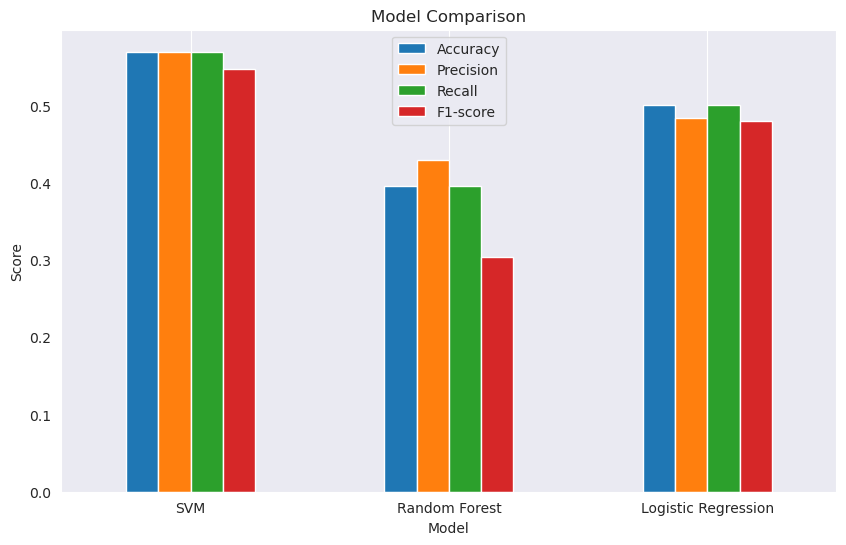

In [13]:
results = pd.DataFrame({
    "Model": ["SVM", "Random Forest", "Logistic Regression"],
    "Accuracy": [acc_svm, acc_rf, acc_lr],
    "Precision": [pre_svm, pre_rf, pre_lr],
    "Recall": [rec_svm, rec_rf, rec_lr],
    "F1-score": [f1_svm, f1_rf, f1_lr]
})

from IPython.display import display
display(results)

results.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()